# Problem statement
In the telecom industry, customers are able to choose from multiple service providers and actively switch from one operator to another. In this highly competitive market, the telecommunications industry experiences an average of 15-25% annual churn rate. Given the fact that it costs 5-10 times more to acquire a new customer than to retain an existing one, customer retention has now become even more important than customer acquisition.

For many incumbent operators, retaining high profitable customers is the number one business goal. To reduce customer churn, telecom companies need to predict which customers are at high risk of churn. In this project, we will analyze customer-level data of a telecom firm, build predictive models to identify customers at high risk of churn, and identify the main indicators of churn.


todo EDA:
- total charges depending on tenure? is it leaking?
- Better visualisation for all feature distributions
- To include non-numeric columns in the correlation matrix, you can encode them as numeric variables using techniques such as one-hot encoding or label encoding.

todo pre processing:
- SMOTE sample

In [2098]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Set display options for data exploratory analysis
pd.set_option('display.max_columns', None)


In [2099]:
# Read data
df = pd.read_csv('churn_initial_df.csv')

# Data cleansing & Outlier detection
In this section, we will cover the topic of outliers and data cleansing, as well as inspecting missing values. Outliers are data points that deviate significantly from the rest of the data and can skew analysis, while missing values can introduce bias and inaccuracies in data analysis. We will explore different methods for identifying and handling outliers and missing values, including replacing missing values and clamping outliers. These techniques will help to ensure that our data is clean and reliable for further analysis.

In [2100]:
# Inspect the columns, potential null values and data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [2101]:
# Print all unique values for each column.
#   This will help us inspect strange values in columns.
for column in df.columns:
    unique_values = df[column].unique()
    print(f"{column}: {unique_values}")

customerID: ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
gender: ['Female' 'Male']
SeniorCitizen: [0 1]
Partner: ['Yes' 'No']
Dependents: ['No' 'Yes']
tenure: [ 1 34  2 45  8 22 10 28 62 13 16 58 49 25 69 52 71 21 12 30 47 72 17 27
  5 46 11 70 63 43 15 60 18 66  9  3 31 50 64 56  7 42 35 48 29 65 38 68
 32 55 37 36 41  6  4 33 67 23 57 61 14 20 53 40 59 24 44 19 54 51 26  0
 39]
PhoneService: ['No' 'Yes']
MultipleLines: ['No phone service' 'No' 'Yes']
InternetService: ['DSL' 'Fiber optic' 'No']
OnlineSecurity: ['No' 'Yes' 'No internet service']
OnlineBackup: ['Yes' 'No' 'No internet service']
DeviceProtection: ['No' 'Yes' 'No internet service']
TechSupport: ['No' 'Yes' 'No internet service']
StreamingTV: ['No' 'Yes' 'No internet service']
StreamingMovies: ['No' 'Yes' 'No internet service']
Contract: ['Month-to-month' 'One year' 'Two year']
PaperlessBilling: ['Yes' 'No']
PaymentMethod: ['Electronic check' 'Mailed check' 'Bank transfer (automatic)

### Correct values in column
If the column is not properly classified as boolean, it can affect the performance of certain models or analyses that require boolean data. Additionally, it may be misleading to interpret non-boolean columns as boolean, which can lead to incorrect conclusions or actions based on the data.

In [2102]:
# There are some columns that are supposed to have categorical values only,
#   but include more. We need to correct them.

# replace 'No phone service' with NaN values
df['MultipleLines'].replace('No phone service', np.nan, inplace=True)

# replace 'No internet service' with NaN values
df.replace('No internet service', np.nan, inplace=True)

# create a new column 'Has_Internet_Service' which has a value of 1 if any of the columns in a row have a non-NaN value
df['Has_Internet_Service'] = df[['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']].notnull().any(axis=1).astype(int)

# replace 'Yes' with 1 and 'No' with 0
df.replace(['Yes', 'No'], [1, 0], inplace=True)

# fill NaN values with 0s for the new columns
df[['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines']] = df[['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines']].fillna(0).astype('int64')


# Replace Yes, No with 1,0 in all columns where there is
#    only Yes, No values

# Loop through each column
for col in df.columns:
    # Check if column has only 'Yes' and 'No' values
    if set(df[col].unique()) == set(['Yes', 'No']):
        # Replace 'Yes' with 1 and 'No' with 0
        df[col] = df[col].map({'Yes': 1, 'No': 0})


# Define list of columns to convert to numeric
cols_to_convert = ['TotalCharges']

# Loop through each column and convert to float
for col in cols_to_convert:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Convert categorical variables to binary using one-hot encoding
#    The resulting dummy variables are added to the DataFrame as new columns
df = pd.get_dummies(df, columns=["gender", "Contract", "InternetService", "PaymentMethod"])

# Drop the column because it is redundant with Has_Internet_Service column
df.drop('InternetService_0', axis=1, inplace=True)

# Print data types of all columns
print(df.dtypes)

customerID                                  object
SeniorCitizen                                int64
Partner                                      int64
Dependents                                   int64
tenure                                       int64
PhoneService                                 int64
MultipleLines                                int64
OnlineSecurity                               int64
OnlineBackup                                 int64
DeviceProtection                             int64
TechSupport                                  int64
StreamingTV                                  int64
StreamingMovies                              int64
PaperlessBilling                             int64
MonthlyCharges                             float64
TotalCharges                               float64
Churn                                        int64
Has_Internet_Service                         int64
gender_Female                                uint8
gender_Male                    

### Identify duplicates
Duplicate rows can skew summary statistics, such as means and standard deviations, and create biases in machine learning models. They can also cause data redundancy and increase the computational time required to process the data. Therefore, identifying and removing duplicates can improve the quality and reliability of the data used for analysis and modeling.

In [2103]:
def check_for_duplicates(df):
    """Checks for duplicate values in a given dataframe."""
    if df.duplicated().any().any():
        # if any duplicated values exist, print a message indicating their presence
        print("- There are duplicated values in the dataframe.")
    else:
        # if no duplicated values exist, print a message indicating their absence
        print("- There are no duplicated values in the dataframe.")

# Apply function
check_for_duplicates(df)

- There are no duplicated values in the dataframe.


### Missing values
If there are missing values in a dataset, it can impact the statistical power of your analysis, and can even result in incorrect conclusions. Furthermore, many machine learning algorithms require complete data, and missing values can cause errors in these algorithms. Therefore, it is essential to identify and handle missing data appropriately.

In [2104]:
def check_for_missing_values(df):
    """Checks for missing values in a given dataframe."""
    if df.isnull().any().any():
        # create a list of columns with missing values
        null_cols = df.columns[df.isnull().any()].tolist()
        for col in null_cols:
            # for each column with missing values, print a message indicating their presence
            print(f"- There are missing values in the dataframe. Column '{col}' has missing values.")
    else:
        # if no missing values exist, print a message indicating their absence
        print("- There are no missing values in the dataframe.")

# Apply function
check_for_missing_values(df)

- There are missing values in the dataframe. Column 'TotalCharges' has missing values.


In [2105]:
# Based on the previous output, there are missing values in the column 'TotalCharges'
# Therefore, we have to replace NaN values in TotalCharges with 0s
df['TotalCharges'] = df['TotalCharges'].fillna(0).astype('int64')


### Imbalanced dataset
If a dataset is imbalanced, meaning that one class of the target variable is overrepresented compared to the other, the model may learn to predict the majority class more accurately and perform poorly on the minority class. This can result in biased or inaccurate predictions, especially if the minority class is of particular interest. By identifying and addressing class imbalance, such as through resampling techniques or adjusting class weights, a model can be trained to better handle imbalanced data and make more accurate predictions.


In [2106]:
def check_for_imbalanced_dataset(df):
    """Checks for class imbalance in a given dataframe."""
    # count the number of samples in each class
    class_counts = df['Churn'].value_counts()

    # calculate the imbalance ratio
    imbalance_ratio = class_counts.min() / class_counts.sum()

    if imbalance_ratio < 0.3:
        # if the imbalance ratio is below a threshold, print a message indicating class imbalance
        print(f"- The dataframe is imbalanced, with an imbalance ratio of {round(imbalance_ratio, 2)}.")
    else:
        # if the imbalance ratio is above a threshold, print a message indicating class balance
        print(f"- The dataframe is balanced, with an imbalance ratio of {round(imbalance_ratio, 2)}.")

check_for_imbalanced_dataset(df)

- The dataframe is imbalanced, with an imbalance ratio of 0.27.



### Outliers
Flagging outliers in a dataset can be useful in identifying potential errors or anomalies in the data, Additionally, you can use the flags as a feature in your model to improve its accuracy, or use them to create new features that capture the presence of outliers in the data. In this function, outliers are detected by comparing each value to the mean and standard deviation of the column, as well as the 1st and 99th percentiles of the column. The function skips outlier detection for binary columns, and joins the outlier flags DataFrame with the input DataFrame to return a new DataFrame with outlier flags. This function can be useful for identifying and handling outliers before training a model.


In [2107]:
def flag_outliers(df):
    """
    This function takes a pandas DataFrame as input and flags outliers in numerical columns.
    """
    # Create a new DataFrame to store the outlier flags
    outlier_flags = pd.DataFrame(index=df.index)

    # Loop through each numerical column in the input DataFrame
    for col in df.select_dtypes(include=np.number):
        # Skip outlier detection for binary columns
        if df[col].nunique() == 2:
            continue
        
        # Calculate the mean and standard deviation of the column
        col_mean = df[col].mean()
        col_std = df[col].std()

        # Calculate the 1st and 99th percentiles of the column
        col_1st_perc = np.percentile(df[col], 1)
        col_99th_perc = np.percentile(df[col], 99)

        # Calculate the lower and upper bounds for outlier detection
        lower_bound = col_mean - 3 * col_std
        upper_bound = col_mean + 3 * col_std

        # Determine if there are any outliers in the column
        has_outliers = ((df[col] < col_1st_perc) | (df[col] > col_99th_perc) | 
                        (df[col] < lower_bound) | (df[col] > upper_bound)).any()

        # If there are outliers, create a new column in the outlier flags DataFrame
        # that flags whether or not each value in the input column is an outlier
        if has_outliers:
            outlier_flags[f"{col}_outlier"] = (
                (df[col] < col_1st_perc) | (df[col] > col_99th_perc) | 
                (df[col] < lower_bound) | (df[col] > upper_bound)
            ).astype(int)

            print("Outlier column created:", col)
            
        else: print("No outlier columns created")

    # Join the outlier flags DataFrame with the input DataFrame
    df = pd.concat([df, outlier_flags], axis=1)

    # Return the new DataFrame with outlier flags
    return df

# Apply function
df = flag_outliers(df)

Outlier column created: tenure
Outlier column created: MonthlyCharges
Outlier column created: TotalCharges


### Clamp outliers
Clamping outliers in numerical columns can help to improve the overall quality of the data and prevent the model from being biased by the presence of extreme values. By replacing outliers with the nearest in-range values, the distribution of the data becomes more normalized, which can help the model make more accurate predictions. Clamping outliers also helps to avoid the risk of overfitting to the training data, which can happen when the model is trying to learn from extreme and non-representative values.

In [2108]:
def clamp_outliers(df):
    """
    Replace values in numerical columns that are more than 3 standard deviations from the mean,
    higher than the 99th percentile or lower than the 1st percentile with the nearest value that is in range.

    Args:
    df: pandas DataFrame object.

    Returns:
    pandas DataFrame object with outliers clamped.
    """
    print("Columns to be modified: ")
    for col in df.select_dtypes(include=[np.number]):
        if len(df[col].unique()) == 2:
            continue
        lower_bound = df[col].quantile(0.01)
        upper_bound = df[col].quantile(0.99)
        std_dev = df[col].std()
        outlier_mask = (df[col] < (df[col].mean() - (3 * std_dev))) | (df[col] > (df[col].mean() + (3 * std_dev))) | (df[col] < lower_bound) | (df[col] > upper_bound)
        num_outliers = len(df[outlier_mask].index)
        if num_outliers > 0:
            print(col)
            df[col] = np.clip(df[col], lower_bound, upper_bound)
    print(f"\n{num_outliers} customer IDs affected.")
    return df

# Apply function
df = clamp_outliers(df)


Columns to be modified: 
tenure
MonthlyCharges
TotalCharges

86 customer IDs affected.


### Optional
It is generally a good practice to scale or normalize your data before using it for model training with XGBoost. The main reason for doing this is to ensure that all features contribute equally to the model and to avoid the domination of certain features over others.

For example, if you do not scale or normalize the TotalCharges feature, it may dominate over other features that have smaller values, causing the model to become biased towards it. By scaling or normalizing the features, you can bring them to the same scale and make them equally important for the model.

Therefore, it is recommended to scale or normalize your data before using it for model training with XGBoost. There are several methods for scaling or normalization, including StandardScaler, MinMaxScaler, and RobustScaler. You can choose the one that best suits your data and the specific problem you are trying to solve.

In [2109]:
# from sklearn.preprocessing import MinMaxScaler

# # Define the columns to normalize
# cols_to_normalize = ['tenure', 'MonthlyCharges', 'TotalCharges']

# # Create the MinMaxScaler object
# scaler = MinMaxScaler()

# # Fit and transform the data
# df[cols_to_normalize] = scaler.fit_transform(df[cols_to_normalize])


# Data visualisation
Correlation analysis is a statistical technique that allows us to measure the strength and direction of the relationship between two variables. In the context of customer churn, it can help us identify which factors are most closely associated with customer attrition. By identifying these factors, we can gain insights into the underlying drivers of churn and potentially intervene to improve customer retention. Ultimately, a better understanding of the factors driving churn can help businesses make more informed decisions and take proactive steps to reduce customer attrition and drive long-term growth.

In [2110]:
# What is the overall churn?
print("Overall churn rate:", round(df[df['Churn'] == 1].customerID.nunique() / df.customerID.nunique(),2))

Overall churn rate: 0.27


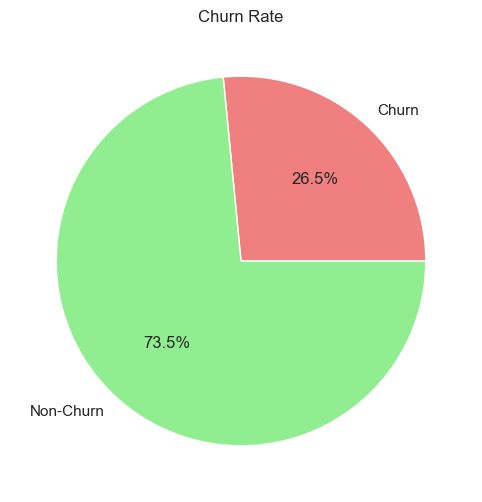

In [2111]:
# Calculate the churn and non-churn counts
churn_count = df[df['Churn'] == 1].customerID.nunique()
non_churn_count = df[df['Churn'] == 0].customerID.nunique()

# Set up the plot size and title
plt.figure(figsize=(8, 6))
plt.title('Churn Rate')

# Set the colors for the pie chart sections
colors = ['lightcoral', 'lightgreen']

# Create the pie chart
plt.pie([churn_count, non_churn_count], labels=['Churn', 'Non-Churn'], autopct='%1.1f%%', colors=colors)

# Display the plot
plt.show()


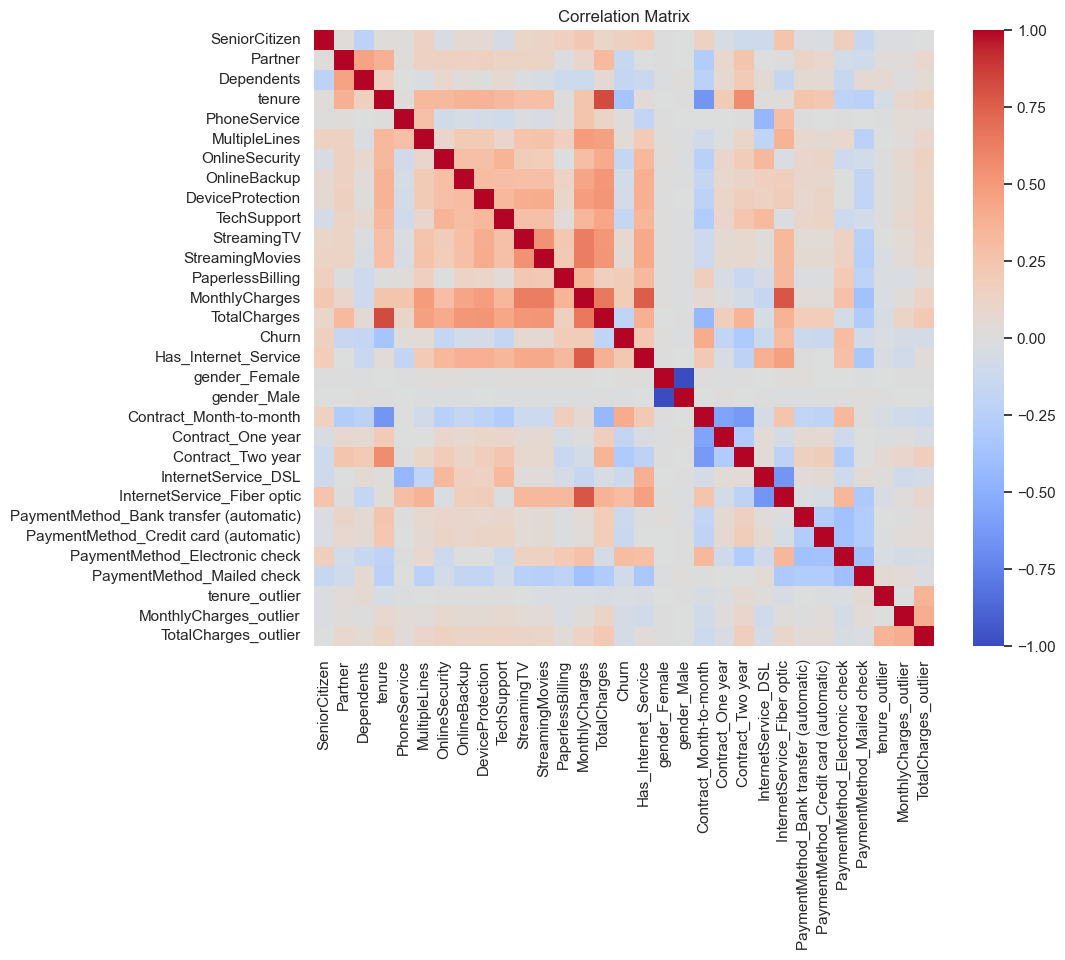

In [2112]:
# Create a correlation matrix
corr_matrix = df.corr()

# Set up the plot size
sns.set(rc={'figure.figsize':(10,8)})

# Plot the correlation matrix as a heatmap
sns.heatmap(corr_matrix, cmap='coolwarm')
plt.title('Correlation Matrix')

# Display the plot
plt.show()


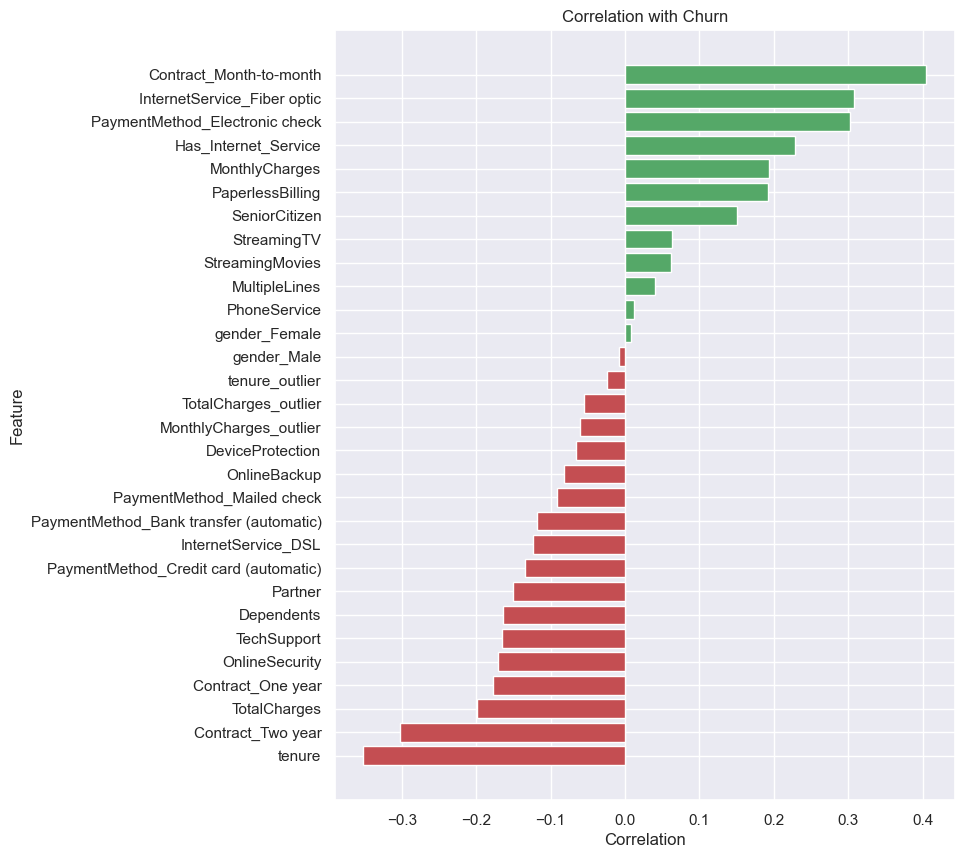

In [2113]:
# Load your correlation data into a pandas dataframe
corr_df = pd.DataFrame({'Feature': corr_churn.index, 'Correlation': corr_churn.values})

# Remove the 'Churn' feature from the dataframe
corr_df = corr_df[corr_df['Feature'] != 'Churn']

# Sort the dataframe by correlation values
sorted_corr_df = corr_df.sort_values(by='Correlation')

# Extract the feature names and correlation values as numpy arrays
features = sorted_corr_df['Feature'].values
corr_values = sorted_corr_df['Correlation'].values

# Assign colors to the bars based on their values
colors = np.where(corr_values > 0, 'g', 'r')

# Set the figure size
fig, ax = plt.subplots(figsize=(8, 10))

# Plot the horizontal bar chart
ax.barh(features, corr_values, color=colors)

# Add labels and title to the plot
ax.set_xlabel('Correlation')
ax.set_ylabel('Feature')
ax.set_title('Correlation with Churn')

plt.show()


The positive correlation of the "Contract_Month-to-month" feature with churn means that customers who are on a monthly contract are more likely to churn than customers who are on a longer-term contract. This could be because customers on monthly contracts have more flexibility to switch providers without penalties or fees, compared to those on longer-term contracts.

The negative correlation of "tenure" with churn means that the longer a customer has been with a provider, the less likely they are to churn. This could be because customers who have been with a provider for a longer period of time have become more loyal, or have built up a greater level of satisfaction with the service over time.

We can display the top correlation features in absolute values in order to have a more informative view.

In [2114]:
# Create correlation between Churn and other features ordered
#  by absolute correlation descending 

# Load your correlation data into a pandas dataframe
corr_df = pd.DataFrame({'Feature': corr_churn.index, 'Correlation': corr_churn.values})

# Remove the 'Churn' feature from the dataframe
corr_df = corr_df[corr_df['Feature'] != 'Churn']

# Add a new column with absolute correlation values
corr_df['Abs_Correlation'] = abs(corr_df['Correlation'])

# Sort the dataframe by absolute correlation values
sorted_corr_df = corr_df.sort_values(by='Abs_Correlation', ascending=False).reset_index(drop=True)

# Display the sorted dataframe
sorted_corr_df[['Feature', 'Correlation']].head(10)


,Feature,Correlation
0,Contract_Month-to-month,0.405103
1,tenure,-0.352296
2,InternetService_Fiber optic,0.308020
3,Contract_Two year,-0.302253
4,PaymentMethod_Electronic check,0.301919
5,Has_Internet_Service,0.227890
6,TotalCharges,-0.198360
7,MonthlyCharges,0.193646
8,PaperlessBilling,0.191825
9,Contract_One year,-0.177820


<AxesSubplot:xlabel='Churn', ylabel='Count'>

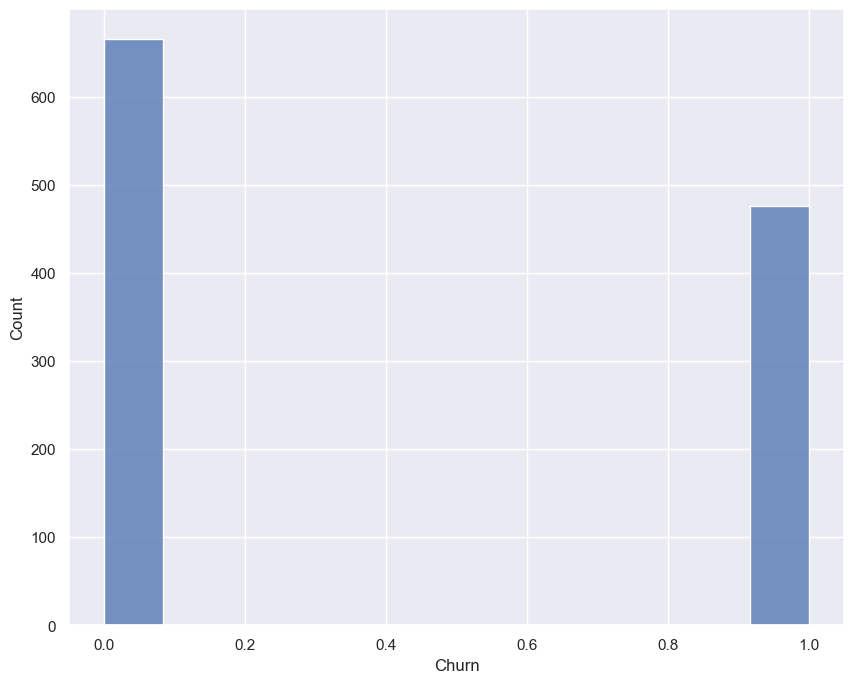

In [2115]:
# Filter the dataset to include only SeniorCitizen users
senior_users = df[df['SeniorCitizen'] == 1]

# Plot the distribution of MonthlyCharges for SeniorCitizen users using a histogram
sns.histplot(data=senior_users, x="Churn")


In [2116]:
# Calculate the total number of SeniorCitizen users
total_seniors = df[df['SeniorCitizen'] == 1].shape[0]

# Calculate the number of SeniorCitizen users who churned
churned_seniors = df[(df['SeniorCitizen'] == 1) & (df['Churn'] == 1)].shape[0]

# Calculate the churn rate for SeniorCitizen users
senior_churn_rate = churned_seniors / total_seniors

print("Churn rate for SeniorCitizen users: {:.2%}".format(senior_churn_rate))


Churn rate for SeniorCitizen users: 41.68%


In [2117]:
# # Drop the customerID column
# df1 = df.drop("customerID", axis=1)

# # Plot the distribution of the numerical columns
# num_cols = df1.select_dtypes(include=['float64', 'int64']).columns.tolist()
# for col in num_cols:
#     sns.displot(df1, x=col)

# # Plot the distribution of the categorical columns
# cat_cols = df1.select_dtypes(include=['object']).columns.tolist()
# for col in cat_cols:
#     sns.catplot(data=df1, x=col, kind='count')

# # Show the plots
# plt.show()

In [2118]:
# # Drop the customerID column
# df1 = df.drop("customerID", axis=1)

# # Compute the correlation matrix
# corr_matrix = df1.corr()

# # Plot the correlation matrix as a heatmap
# sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

# # Display the plot
# plt.show()

In [2119]:


df


,customerID,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,Has_Internet_Service,gender_Female,gender_Male,Contract_Month-to-month,Contract_One year,Contract_Two year,InternetService_DSL,InternetService_Fiber optic,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,tenure_outlier,MonthlyCharges_outlier,TotalCharges_outlier
0,7590-VHVEG,0,1,0,1.0,0,0,0,1,0,0,0,0,1,29.85,29.0,0,1,1,0,1,0,0,1,0,0,0,1,0,0,0,0
1,5575-GNVDE,0,0,0,34.0,1,0,1,0,1,0,0,0,0,56.95,1889.0,0,1,0,1,0,1,0,1,0,0,0,0,1,0,0,0
2,3668-QPYBK,0,0,0,2.0,1,0,1,1,0,0,0,0,1,53.85,108.0,1,1,0,1,1,0,0,1,0,0,0,0,1,0,0,0
3,7795-CFOCW,0,0,0,45.0,0,0,1,0,1,1,0,0,0,42.30,1840.0,0,1,0,1,0,1,0,1,0,1,0,0,0,0,0,0
4,9237-HQITU,0,0,0,2.0,1,0,0,0,0,0,0,0,1,70.70,151.0,1,1,1,0,1,0,0,0,1,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,0,1,1,24.0,1,1,1,0,1,1,1,1,1,84.80,1990.0,0,1,0,1,0,1,0,1,0,0,0,0,1,0,0,0
7039,2234-XADUH,0,1,1,72.0,1,1,0,1,1,0,1,1,1,103.20,7362.0,0,1,1,0,0,1,0,0,1,0,1,0,0,0,0,0
7040,4801-JZAZL,0,1,1,11.0,0,0,1,0,0,0,0,0,1,29.60,346.0,0,1,1,0,1,0,0,1,0,0,0,1,0,0,0,0
7041,8361-LTMKD,1,1,0,4.0,1,1,0,0,0,0,0,0,1,74.40,306.0,1,1,0,1,1,0,0,0,1,0,0,0,1,0,0,0


In [2120]:
df.columns

Index(['customerID', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'PaperlessBilling', 'MonthlyCharges', 'TotalCharges', 'Churn',
       'Has_Internet_Service', 'gender_Female', 'gender_Male',
       'Contract_Month-to-month', 'Contract_One year', 'Contract_Two year',
       'InternetService_DSL', 'InternetService_Fiber optic',
       'PaymentMethod_Bank transfer (automatic)',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check',
       'tenure_outlier', 'MonthlyCharges_outlier', 'TotalCharges_outlier'],
      dtype='object')

In [2121]:
# Overall churn
df[df['Churn'] == 1].customerID.nunique() / df.customerID.nunique()

0.2653698707936959

In [2122]:
# How many users over total dont have Internet service?


In [2123]:
# do they churn more? no the other way around
print(round(df.loc[(df["SeniorCitizen"] == 1) & (df["Churn"] == 1)].customerID.nunique() / df[df['SeniorCitizen'] == 1].customerID.nunique(), 2))
print(round(df.loc[(df["SeniorCitizen"] == 0) & (df["Churn"] == 1)].customerID.nunique() / df[df['SeniorCitizen'] == 0].customerID.nunique(), 2))


print(round(df.loc[(df["gender_Female"] == 0) & (df["Churn"] == 1)].customerID.nunique() / df[df['gender_Female'] == 0].customerID.nunique(), 2))
print(round(df.loc[(df["gender_Female"] == 0) & (df["Churn"] == 1)].customerID.nunique() / df[df['gender_Female'] == 0].customerID.nunique(), 2))


print(round(df.loc[(df["Has_Internet_Service"] == 0) & (df["PaymentMethod_Mailed check"] == 1) & (df["Churn"] == 1)].customerID.nunique() / df[(df["Has_Internet_Service"] == 0) & (df["PaymentMethod_Mailed check"] == 1)].customerID.nunique(), 2))

# print(round(df.loc[(df["PaymentMethod_Mailed check"] == 1) & (df["Churn"] == 1)].customerID.nunique() / df[df['Has_Internet_Service'] == 1].customerID.nunique(), 2))



# print(round(df.loc[(df["InternetService"] == 'No') & (df["Churn"] == 1)].customerID.nunique() / df[df['InternetService'] != 'No'].customerID.nunique(), 2))


0.42
0.24
0.26
0.26
0.1


In [2124]:
# do we have weird cases in data: no
# df[(df['InternetService'] == 'No') & (df['PhoneService'] == 'No')]

In [2125]:
df.customerID.nunique()

7043

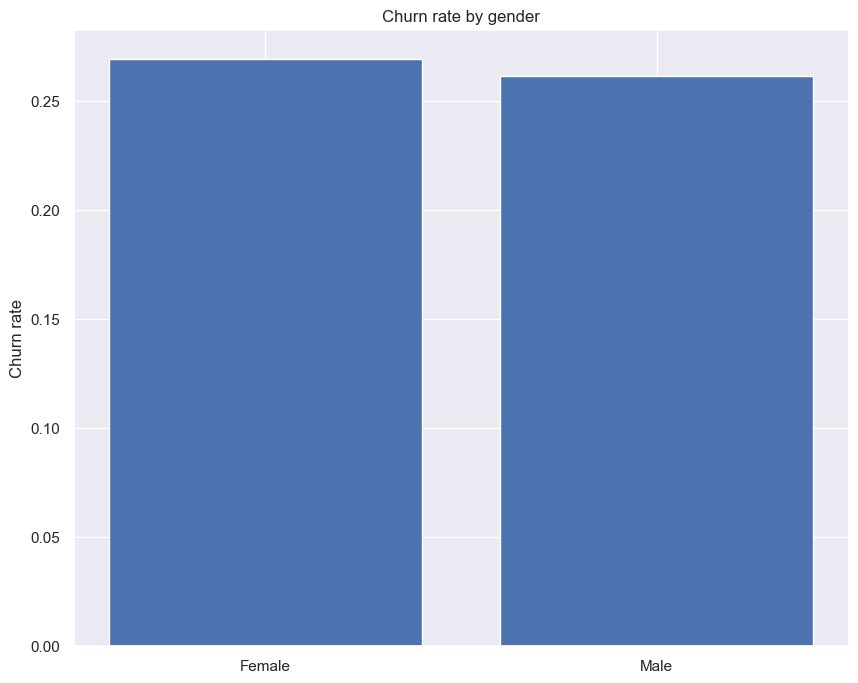

In [2126]:
# Calculate churn rate for male and female customers where churn is equal to 1
female_churn_rate = df[(df["gender_Female"] == 1) & (df["Churn"] == 1)]["Churn"].count() / df[df["gender_Female"] == 1]["Churn"].count()
male_churn_rate = df[(df["gender_Male"] == 1) & (df["Churn"] == 1)]["Churn"].count() / df[df["gender_Male"] == 1]["Churn"].count()

# Create a bar chart
fig, ax = plt.subplots()
ax.bar(["Female", "Male"], [female_churn_rate, male_churn_rate])
ax.set_ylabel("Churn rate")
ax.set_title("Churn rate by gender")
plt.show()


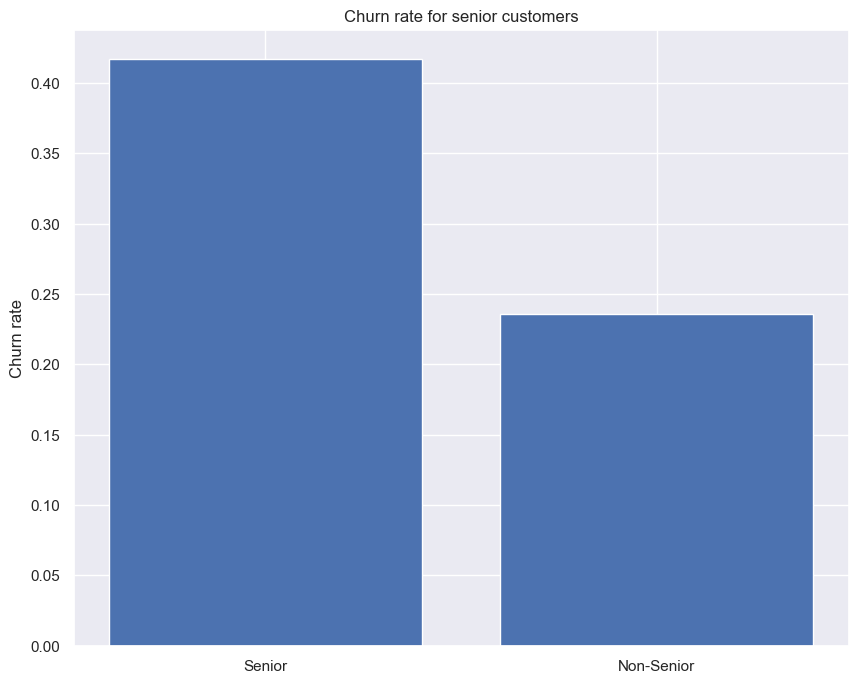

In [2127]:
# Calculate churn rate for senior customers where churn is equal to 1
senior_churn_rate = df[(df["SeniorCitizen"] == 1) & (df["Churn"] == 1)]["Churn"].count() / df[df["SeniorCitizen"] == 1]["Churn"].count()
non_senior_churn_rate = df[(df["SeniorCitizen"] == 0) & (df["Churn"] == 1)]["Churn"].count() / df[df["SeniorCitizen"] == 0]["Churn"].count()

# Create a bar chart
fig, ax = plt.subplots()
ax.bar(["Senior", "Non-Senior"], [senior_churn_rate, non_senior_churn_rate])
ax.set_ylabel("Churn rate")
ax.set_title("Churn rate for senior customers")
plt.show()
